## XAI

此notebook提供了模型可解释性(XAI)工具的使用方式，支持计算单个样本的特征贡献度（attribution），帮助用户更好的理解预测结果是如何形成的。

具体流程如下：

## 1、导入数据库

In [1]:
import numpy as np
import pandas as pd
import paddle
import matplotlib.pyplot as plt

np.random.seed(123456)
paddle.seed(123456)

from paddlets import TSDataset
from paddlets.models.forecasting import NBEATSModel
from paddlets.transform import StandardScaler
from paddlets.pipeline.pipeline import Pipeline
from paddlets.utils.backtest import backtest
from paddlets.analysis import Seasonality, Acf, Correlation
from paddlets.datasets.repository import dataset_list, get_dataset, DATASETS
from paddlets.xai.post_hoc.shap_explainer import ShapExplainer

## 2、导入数据

In [2]:
data = get_dataset('ECL')

In [3]:
from paddlets.datasets.tsdataset import TimeSeries
#选择一部分列放入known_cov
ts_known = TimeSeries(data[['MT_001', ]], freq='1H').copy()

In [4]:
#减少列数提高后续计算效率
ts_cols = data.columns
keep_cols = ['MT_000', ]
remove_cols = []
for col, types in ts_cols.items():
    if (types is 'target'):
        continue
    if (col not in keep_cols):
        remove_cols.append(col)
remove_cols

data.drop(remove_cols)

In [5]:
data.set_known_cov(ts_known)

## 3、样本划分

In [6]:
data, _ = data.split('2014-06-30')
train_data, test_data = data.split('2014-06-15')
train_data, val_data = train_data.split('2014-06-01')

## 4、参数选择

In [7]:
#目标列历史长度生成特征
in_chunk_len = 24
#预测未来长度
out_chunk_len = 24
#训练区间与预测区间相隔长度
skip_chunk_len = 0
#sampling_stride
sampling_stride = 24
#模型额外参数指定
max_epochs = 10
patience = 5

## 5、构建场景pipeline

In [8]:
pipeline_list = [(StandardScaler, {}), 
                 (NBEATSModel, {'in_chunk_len': in_chunk_len, 
                                'out_chunk_len': out_chunk_len, 
                                'skip_chunk_len': skip_chunk_len, 
                                'max_epochs': max_epochs, 
                                'patience': patience})
                ]
pipe = Pipeline(pipeline_list)

## 6、pipeline训练

In [9]:
pipe.fit(train_data, val_data)

[2022-12-21 14:32:52,081] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 0.369674| val_0_mae: 0.399982| 0:00:15s
[2022-12-21 14:33:07,176] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.212269| val_0_mae: 0.359164| 0:00:30s
[2022-12-21 14:33:21,983] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.177731| val_0_mae: 0.346541| 0:00:44s
[2022-12-21 14:33:36,705] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.156180| val_0_mae: 0.328719| 0:00:59s
[2022-12-21 14:33:51,574] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.141895| val_0_mae: 0.327692| 0:01:14s
[2022-12-21 14:34:06,088] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.129950| val_0_mae: 0.320174| 0:01:29s
[2022-12-21 14:34:20,602] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.120311| val_0_mae: 0.330323| 0:01:43s
[2022-12-21 14:34:34,977] [paddlets.models.common.callb

## 7、pipeline预测

In [10]:
test_data_fea, test_data = test_data.split('2014-06-29 00:00:00')
pred = pipe.predict(test_data_fea)

In [11]:
#预测结果展示
print(pred)

                          MT_320
2014-06-29 01:00:00  2932.833496
2014-06-29 02:00:00  2855.155518
2014-06-29 03:00:00  2675.178955
2014-06-29 04:00:00  2754.528076
2014-06-29 05:00:00  2670.689209
2014-06-29 06:00:00  2673.067383
2014-06-29 07:00:00  2663.239502
2014-06-29 08:00:00  2773.476807
2014-06-29 09:00:00  2811.970215
2014-06-29 10:00:00  2951.933594
2014-06-29 11:00:00  2978.755859
2014-06-29 12:00:00  3058.016357
2014-06-29 13:00:00  3082.769531
2014-06-29 14:00:00  3219.403809
2014-06-29 15:00:00  3094.723877
2014-06-29 16:00:00  3279.659668
2014-06-29 17:00:00  3229.147705
2014-06-29 18:00:00  3173.135986
2014-06-29 19:00:00  3105.273193
2014-06-29 20:00:00  2950.284912
2014-06-29 21:00:00  2961.639404
2014-06-29 22:00:00  2962.938965
2014-06-29 23:00:00  2933.111084
2014-06-30 00:00:00  2880.761719


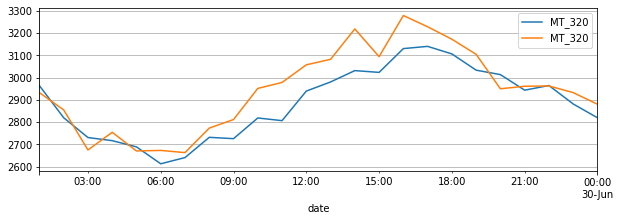

In [12]:
#预测效果展示，黄线为预测值，蓝线为真实值
plt.figure()
test_data.plot()
pred.plot()
plt.show()

## 8、解释性策略

基于kernel shap方法解释预测结果

`ShapExplainer`: 帮助用户实现PaddleTS模型与shap解释器之间的链接桥梁，更好的帮助用户理解输出结果性质

- `model`: 目前支持输入模型对象包括：PaddleBaseModel及其派生类、Pipeline及其派生类两种(shap_method='deep'时暂时仅支持PaddleBaseModel及其派生类对象)

- `background_data`: 背景板数据，通常为用户训练模型使用的训练集

- `background_sample_number`: 针对背景板数据采样条目数量（数量越多，计算效率越低）

- `shap_method`: 支持的shap解释性方法策略，目前仅支持kernel shap方法

- `task_type`: 支持的模型任务类型，目前仅支持回归任务

- `seed`: 背景板采用随机数种子

- `use_paddleloader`: 是否使用paddle loader的方式加速训练效率，目前仅支持PaddleBaseModel及其派生类且当shap_method='kernel'时生效

- `kwargs`: 其他参数信息用于传入shap_method

In [13]:
#base data process.
se = ShapExplainer(pipe, train_data, background_sample_number=10, keep_index=True, use_paddleloader=False)

`ShapExplainer.explain`: 帮助用户计算需要解释性的样本，给出特征贡献度

- `foreground_data`: 需要解释性的数据集合，一般为预测数据集
- `nsamples`: 解释每个预测时重新评估模型的次数。更多的样本导致SHAP值的方差估计更低。默认nsamples=100
- `sample_start_index`: 样本索引，默认仅一条样本（最后一条）
- `sample_num`: foreground_data数据集产出的样本中需要解释性样本的数量，默认最后一条（即预测未来时间的样本）
- `kwargs`: 其他参数用于传入shap.explainer.shap_values

In [14]:
shap_value = se.explain(test_data_fea, nsamples=100)

  0%|          | 0/1 [00:00<?, ?it/s]

[2022-12-21 14:35:07,112] [shap] [INFO] num_full_subsets = 0
[2022-12-21 14:35:07,113] [shap] [INFO] num_paired_subset_sizes = 47
[2022-12-21 14:35:07,117] [shap] [INFO] weight_left = 1.0
[2022-12-21 14:38:13,863] [shap] [INFO] np.sum(w_aug) = 96.0
[2022-12-21 14:38:13,864] [shap] [INFO] np.sum(self.kernelWeights) = 0.9999999999999999
[2022-12-21 14:38:14,085] [shap] [INFO] np.sum(w_aug) = 96.0
[2022-12-21 14:38:14,087] [shap] [INFO] np.sum(self.kernelWeights) = 0.9999999999999999
[2022-12-21 14:38:14,118] [shap] [INFO] np.sum(w_aug) = 96.0
[2022-12-21 14:38:14,119] [shap] [INFO] np.sum(self.kernelWeights) = 0.9999999999999999
[2022-12-21 14:38:14,154] [shap] [INFO] np.sum(w_aug) = 96.0
[2022-12-21 14:38:14,155] [shap] [INFO] np.sum(self.kernelWeights) = 0.9999999999999999
[2022-12-21 14:38:14,187] [shap] [INFO] np.sum(w_aug) = 96.0
[2022-12-21 14:38:14,188] [shap] [INFO] np.sum(self.kernelWeights) = 0.9999999999999999
[2022-12-21 14:38:14,226] [shap] [INFO] np.sum(w_aug) = 96.0
[2022-

### 8.1 特征贡献叠加图

`ShapExplainer.force_plot`: 采用加性图层展示需要解释性的样本数据时间点。展示结果中lag_0代表in_chunk_len最后一个时刻，lag_1代表out_chunk_len的第一个时刻

- `out_chunk_indice`: 待解释的时间点索引

- `sample_index`: 参与计算的样本索引，默认第一条

- `kwargs`: 其他参数传入shap.force_plot

NOTE：图层内容具体如下
- 图层下面代表当前预测样本的某个输入时间步的某个特征具体数值（如MT_320:target_lag_0 = 2983.0，代表着MT320特征在in_chunk_len最后一个时间步的数值为2983.0，该特征属于target变量）
- 蓝色框代表该变量带来的特征贡献度为负值，使得base value(背景板在该预测时间步的预测均值)，红色框该变量带来的特征贡献度为正值
- 方框长度代表着特征贡献度的绝对值大小


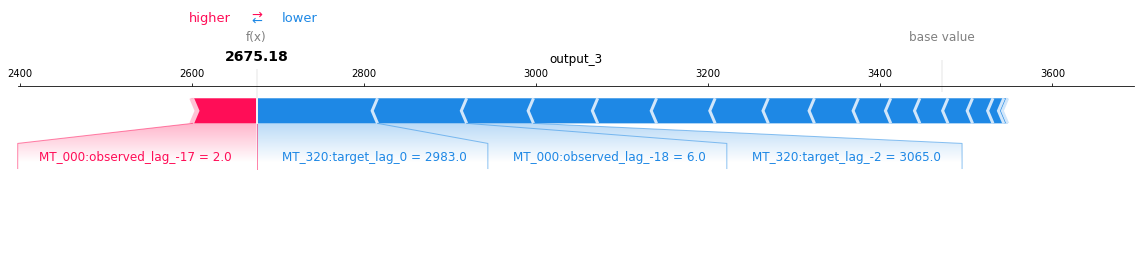

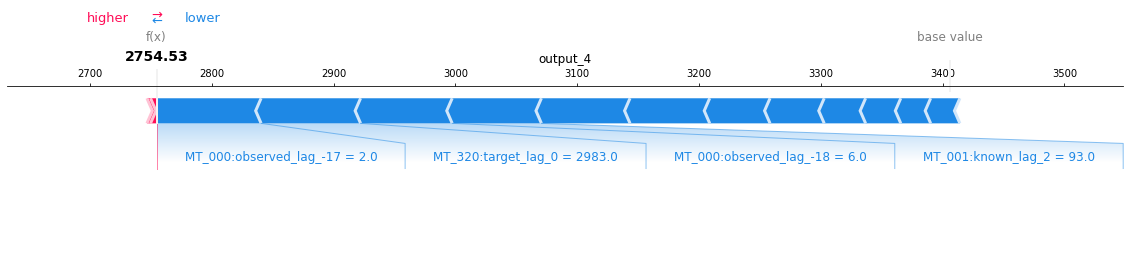

In [15]:
#contribution_threshold控制显示下面内容的变量，仅该特征贡献度占所有特征贡献度总和的百分比大于该值时显示
se.force_plot(out_chunk_indice=[3, 4], sample_index=0, contribution_threshold=0.05)

### 8.2 特征重要性展示

`ShapExplainer.summary_plot`: 针对指定的待预测时间点(out_chunk_indice)计算特征贡献度数值并排序

- `out_chunk_indice`: 待解释的时间点索引

- `sample_index`: 被解释的样本索引，默认第一条

- `kwargs`: 其他参数传入shap.summary_plot

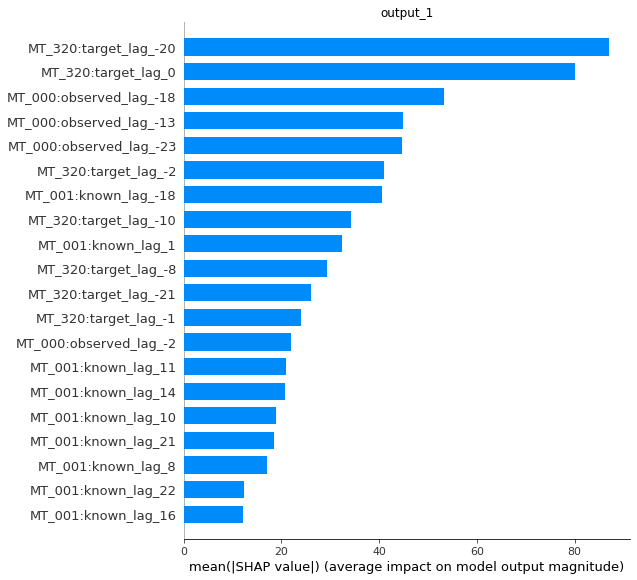

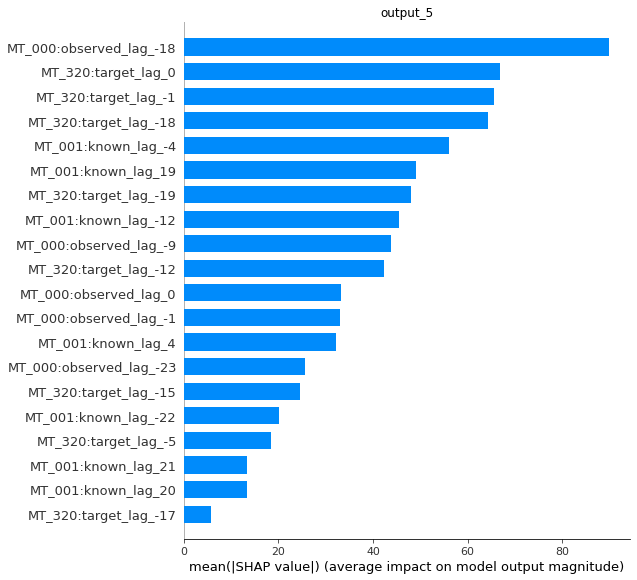

In [24]:
se.summary_plot(out_chunk_indice=[1, 5], sample_index=0)

### 8.3 多维度输出贡献值展示

`ShapExplainer.plot`: 计算参与计算的样本特征贡献度数值在不同维度对预测向量的影响程度

- `method`: 展示方法，可选：'OI'(预测时间长度out_chunk_len和输入时间长度in_chunk_len + out_chunk_len(known_cov存在时)), 'OV'(预测时间长度out_chunk_len和特征变量variable), 'IV'(输入时间长度和特征变量), 'I'(输入时间长度), and 'V'(特征变量).

- `sample_index`: 参与计算的样本索引，默认第一条

- `kwargs`: 其他参数

#### 8.3.1 特征变量

Note: 以下展示每个特征变量在所有输入时间步和所有输出时间步上的特征贡献度

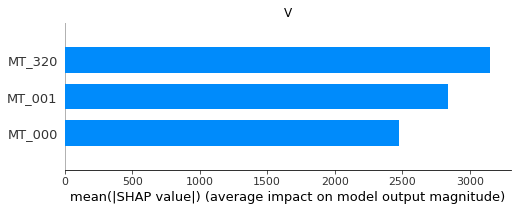

In [17]:
#展示每个特征变量的特征贡献度
se.plot(method='V')

#### 8.3.2 输入时间步

Note: 以下展示每个输入时间步在所有特征和所有输出时间步上的特征贡献度（TOP20）

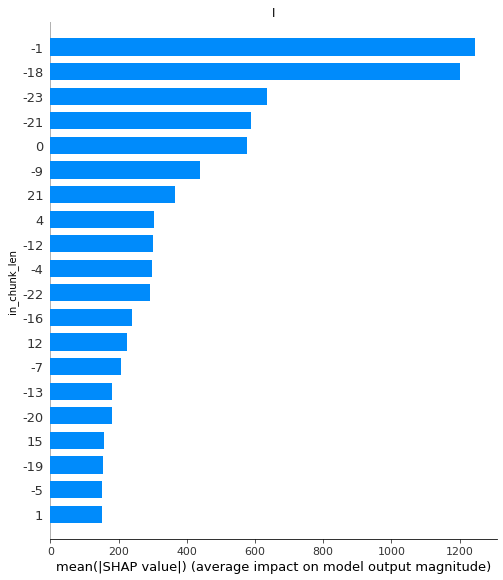

In [18]:
#展示每个输入时间步的特征贡献度
se.plot(method='I')

#### 8.3.3 输入时间步与输出时间步

Note: 以下展示每个输入时间步和每个输出时间步在所有特征变量上的特征贡献度

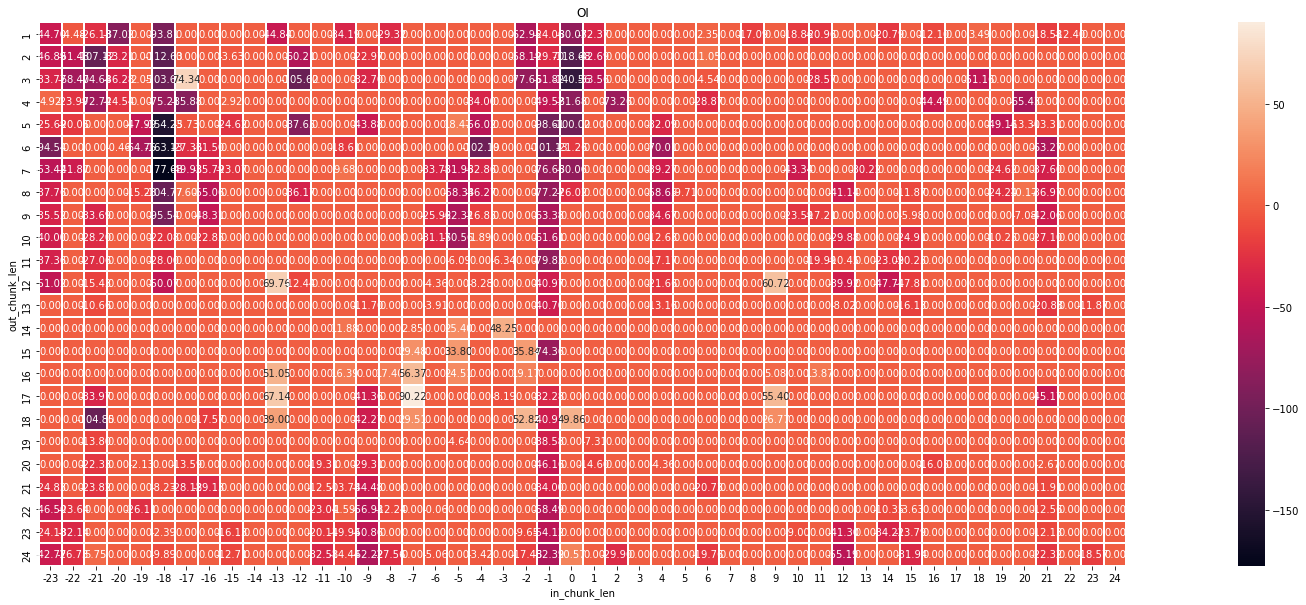

In [19]:
#展示每个输入时间步与每个输出时间步之间的特征贡献度
se.plot(method='OI')

#### 8.3.4 特征变量和输出时间步

Note: 以下展示每个特征变量和每个输出时间步在所有输入时间步上的特征贡献度

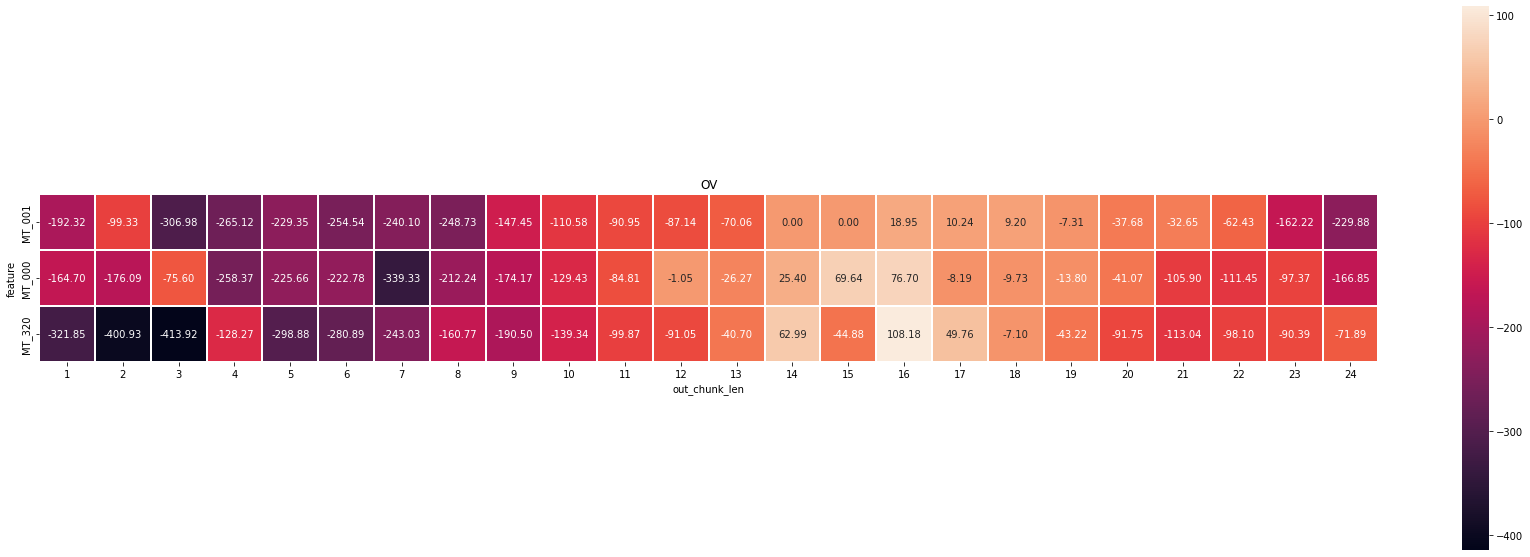

In [20]:
#展示每个特征变量与每个输出时间步之间的特征贡献度
se.plot(method='OV')

#### 8.3.5 特征变量和输入时间步

Note: 以下展示每个输入时间步和每个变量在所有输出时间步上的特征贡献度

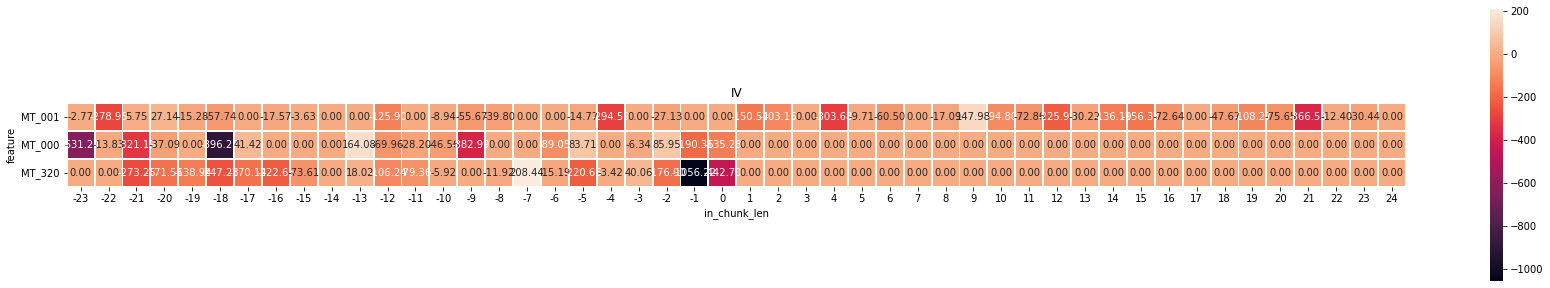

In [21]:
#展示每个输入时间步与每个特征变量之间的特征贡献度
se.plot(method='IV', figsize=(30, 5))